### lecture 9 - Holt Winters methods 

#### Holt-Winters Methods

In the previous section on *Exponentially Weighted Moving Averages* (EWMA), we applied *Simple Exponential Smoothing* using just one smoothing factor, $\alpha$ (alpha). This failed to account for other contributing factors like trend and seasonality.

In this lecture, we'll look at *Double* and *Triple Exponential Smoothing* with the [Holt-Winters Methods](https://otexts.com/fpp2/holt-winters.html).

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [2]:
df = pd.read_csv('./dataset/airline_passengers.csv',index_col='Month',parse_dates=True)

In [3]:
df.dropna(inplace=True)

Note that our DatetimeIndex does not have a frequency. In order to build a Holt-Winters smoothing model, statsmodels needs to know the frequency of the data (whether it's daily, monthly etc.). Since observations occur at the start of each month, we'll use MS.<br>A full list of time series offset aliases can be found <a href='http://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases'>here</a>.

In [4]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

The line df.index.freq = 'MS' sets the frequency of a DatetimeIndex in a pandas DataFrame to 'MS', which stands for "Month Start". This frequency indicates that the data is expected to have a regular interval starting at the beginning of each month.

In [5]:
df.index.freq = 'MS'

In [6]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


#### Simple Exponential Smoothing

A variation of the `statsmodels` Holt-Winters function provides Simple Exponential Smoothing. We'll show that it performs the same calculation of the weighted moving average as the pandas `.ewm()` method:

\[
\begin{split}
y_0 &= x_0 \\
y_t &= (1 - \alpha) y_{t-1} + \alpha x_t,
\end{split}
\]


In [7]:
span = 12

In [8]:
alpha = 2/(span+1)

#### ...using pandas

In [9]:
df['EWMA-12'] = df['Thousands of Passengers'].ewm(alpha=alpha,adjust=False).mean()

In [10]:
df.head()

,Thousands of Passengers,EWMA-12
Month,,
1949-01-01,112,112.000000
1949-02-01,118,112.923077
1949-03-01,132,115.857988
1949-04-01,129,117.879836
1949-05-01,121,118.359861


#### ...using SimpleExpSmoothing module imported from statsmodels

In [11]:
model = SimpleExpSmoothing(df['Thousands of Passengers'])

In [12]:
fitted_model = model.fit(smoothing_level=alpha,optimized=False)

In [13]:
df['SES-12'] = fitted_model.fittedvalues.shift(-1)

In [14]:
df.head()

,Thousands of Passengers,EWMA-12,SES-12
Month,,,
1949-01-01,112,112.000000,112.000000
1949-02-01,118,112.923077,112.923077
1949-03-01,132,115.857988,115.857988
1949-04-01,129,117.879836,117.879836
1949-05-01,121,118.359861,118.359861


<Axes: xlabel='Month'>

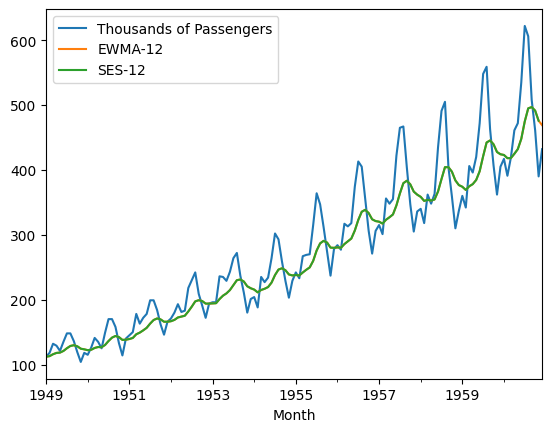

In [15]:
df.plot()

#### Double Exponential Smoothing
Where Simple Exponential Smoothing employs just one smoothing factor $\alpha$ (alpha), Double Exponential Smoothing adds a second smoothing factor $\beta$ (beta) that addresses trends in the data. Like the alpha factor, values for the beta factor fall between zero and one ($0<\beta≤1$). The benefit here is that the model can anticipate future increases or decreases where the level model would only work from recent calculations.

We can also address different types of change (growth/decay) in the trend. If a time series displays a straight-line sloped trend, you would use an <strong>additive</strong> adjustment. If the time series displays an exponential (curved) trend, you would use a <strong>multiplicative</strong> adjustment.

As we move toward forecasting, it's worth noting that both additive and multiplicative adjustments may become exaggerated over time, and require <em>damping</em> that reduces the size of the trend over future periods until it reaches a flat line.

In [16]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

we can say that the growth trend is linear, which means we will use an additive model

In [17]:
df['DES_add_12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add').fit().fittedvalues.shift(-1)

In [18]:
df.head()

,Thousands of Passengers,EWMA-12,SES-12,DES_add_12
Month,,,,
1949-01-01,112,112.000000,112.000000,114.102394
1949-02-01,118,112.923077,112.923077,120.040657
1949-03-01,132,115.857988,115.857988,134.001539
1949-04-01,129,117.879836,117.879836,131.085845
1949-05-01,121,118.359861,118.359861,123.110263


In [19]:
df.columns

Index(['Thousands of Passengers', 'EWMA-12', 'SES-12', 'DES_add_12'], dtype='object')

<Axes: xlabel='Month'>

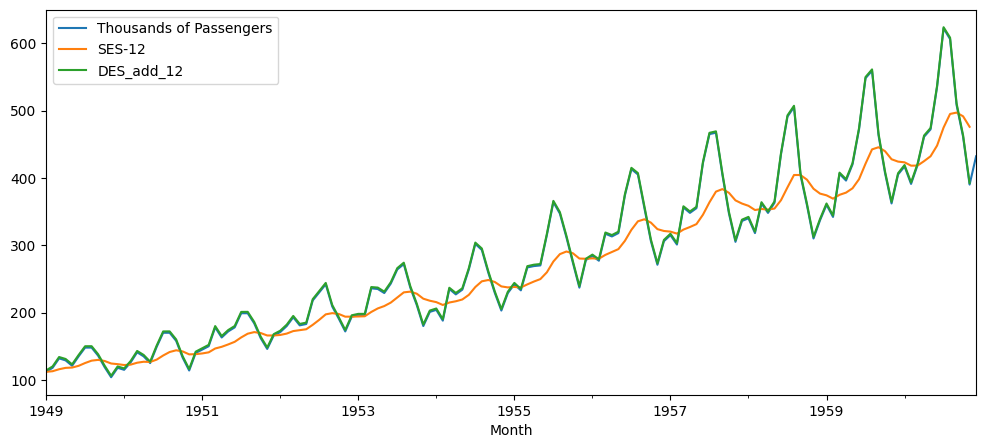

In [20]:
df[['Thousands of Passengers', 'SES-12', 'DES_add_12']].plot(figsize=(12,5))

<Axes: xlabel='Month'>

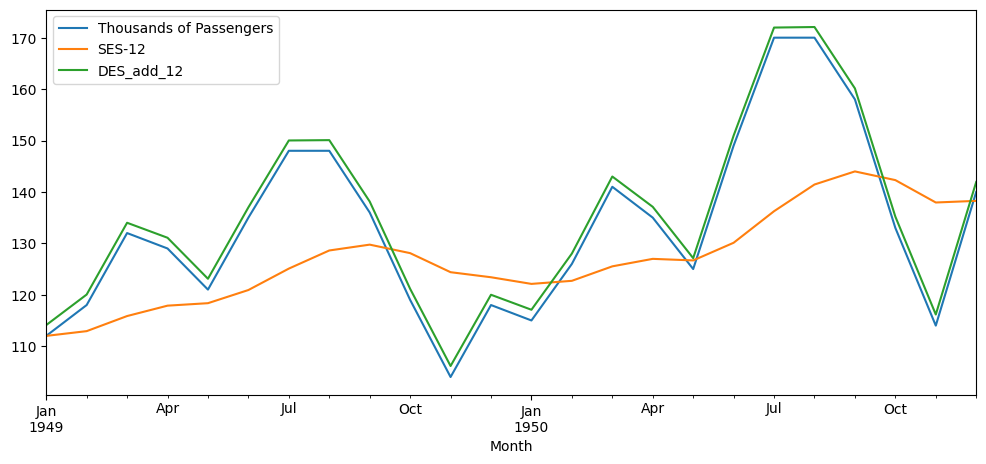

In [21]:
# first 2 years
df[['Thousands of Passengers', 'SES-12', 'DES_add_12']].iloc[:24].plot(figsize=(12,5))

<Axes: xlabel='Month'>

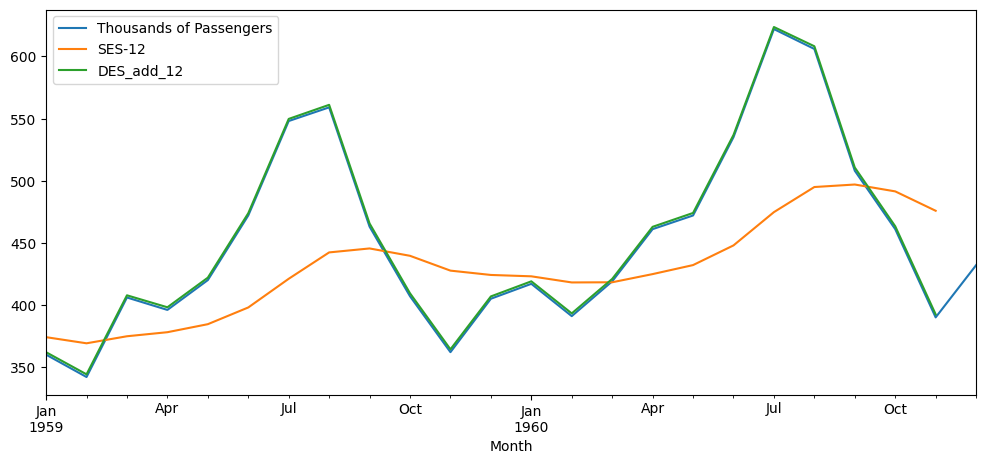

In [22]:
# last 2 years
df[['Thousands of Passengers', 'SES-12', 'DES_add_12']].iloc[-24:].plot(figsize=(12,5))

Here we can see that Double Exponential Smoothing is a much better representation of the time series data. Let's see if using a multiplicative seasonal adjustment helps.

so we are going to do the same things as before except now my double exponential smoothing will assumer that the rate in growth is increasing as times goes on

In [23]:
df['DES_mul_12'] = ExponentialSmoothing(df['Thousands of Passengers'], trend='mul').fit().fittedvalues.shift(-1)

In [24]:
df.head()

,Thousands of Passengers,EWMA-12,SES-12,DES_add_12,DES_mul_12
Month,,,,,
1949-01-01,112,112.000000,112.000000,114.102394,113.990701
1949-02-01,118,112.923077,112.923077,120.040657,120.031669
1949-03-01,132,115.857988,115.857988,134.001539,134.235979
1949-04-01,129,117.879836,117.879836,131.085845,131.270786
1949-05-01,121,118.359861,118.359861,123.110263,123.156267


<Axes: xlabel='Month'>

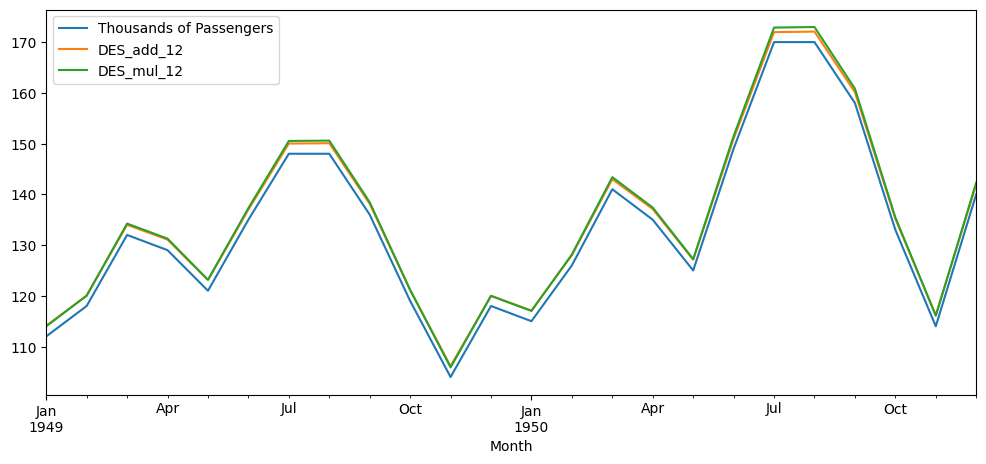

In [25]:
df[['Thousands of Passengers','DES_add_12','DES_mul_12']].iloc[:24].plot(figsize=(12,5))

<Axes: xlabel='Month'>

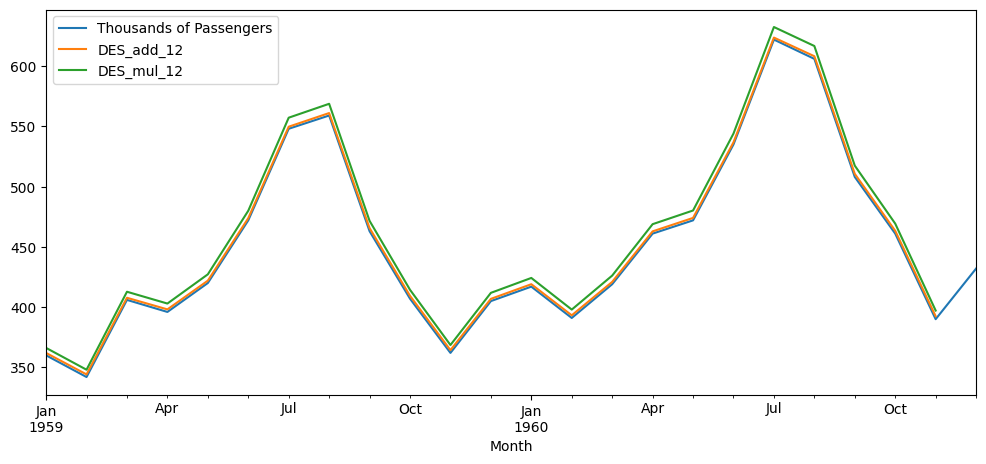

In [26]:
df[['Thousands of Passengers','DES_add_12','DES_mul_12']].iloc[-24:].plot(figsize=(12,5))

#### comparison between models

<Axes: xlabel='Month'>

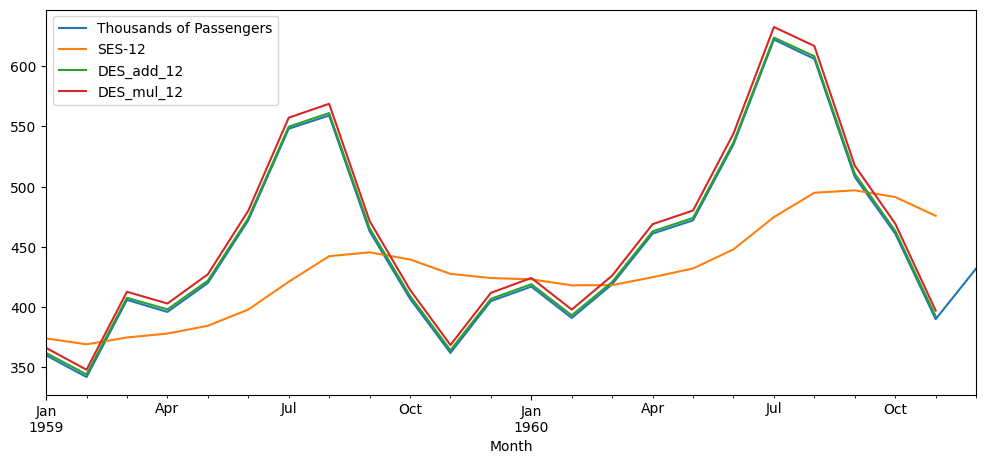

In [27]:
df[['Thousands of Passengers','SES-12','DES_add_12','DES_mul_12']].iloc[-24:].plot(figsize=(12,5))

<Axes: xlabel='Month'>

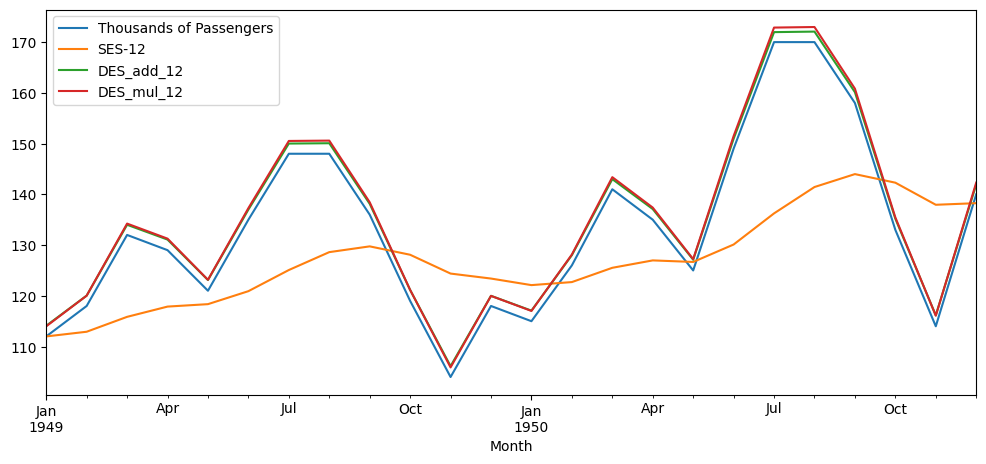

In [28]:
df[['Thousands of Passengers','SES-12','DES_add_12','DES_mul_12']].iloc[:24].plot(figsize=(12,5))

we can see that the additive model still remain the best and is closer to the original data

#### Triple Exponential Smoothing
Triple Exponential Smoothing, the method most closely associated with Holt-Winters, adds support for both trends and seasonality in the data. 

In [37]:
df['TES_add_12'] = ExponentialSmoothing(df['Thousands of Passengers'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues # we have also the seasonality component

<Axes: xlabel='Month'>

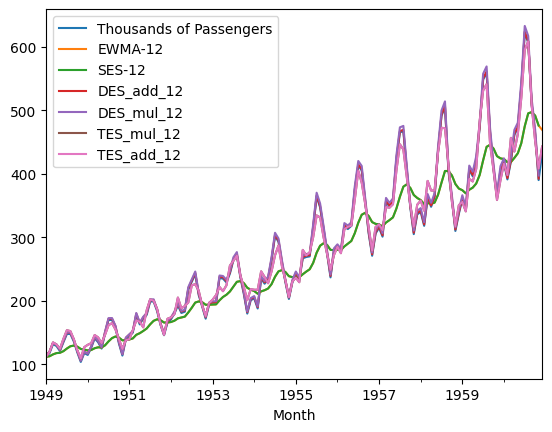

In [38]:
df.plot()

In [39]:
df.columns

Index(['Thousands of Passengers', 'EWMA-12', 'SES-12', 'DES_add_12',
       'DES_mul_12', 'TES_mul_12', 'TES_add_12'],
      dtype='object')

<Axes: xlabel='Month'>

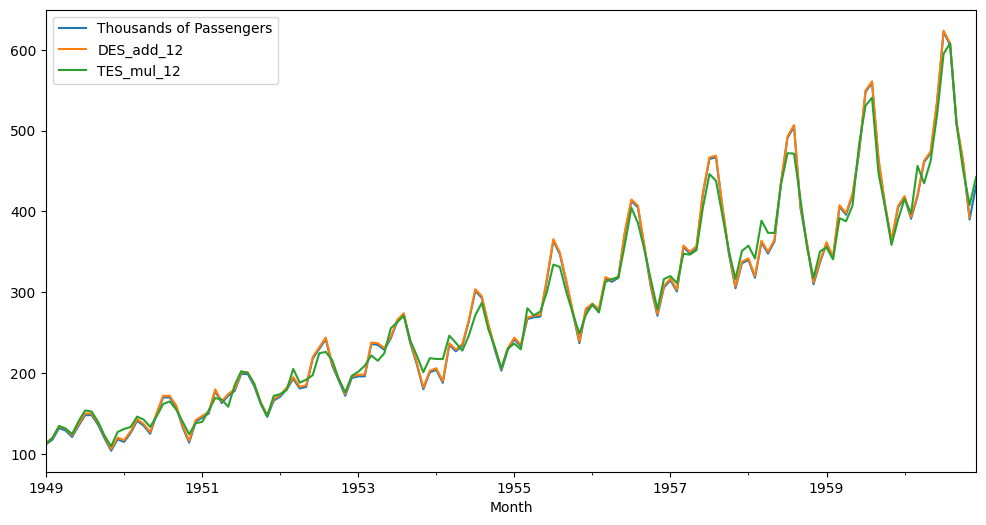

In [40]:
df[['Thousands of Passengers','DES_add_12', 'TES_mul_12']].plot(figsize=(12,6))

<Axes: xlabel='Month'>

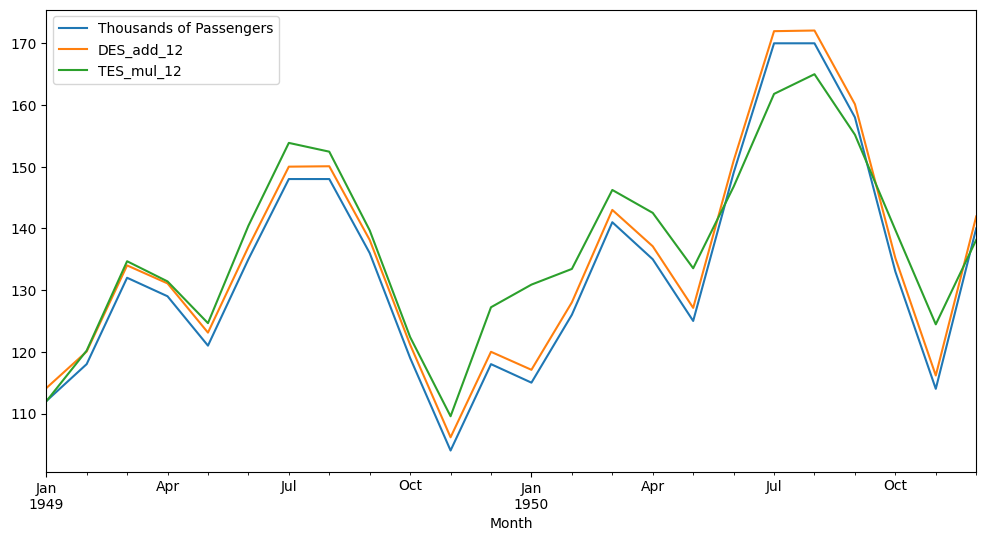

In [44]:
df[['Thousands of Passengers','DES_add_12', 'TES_mul_12']].iloc[:24].plot(figsize=(12,6))

<Axes: xlabel='Month'>

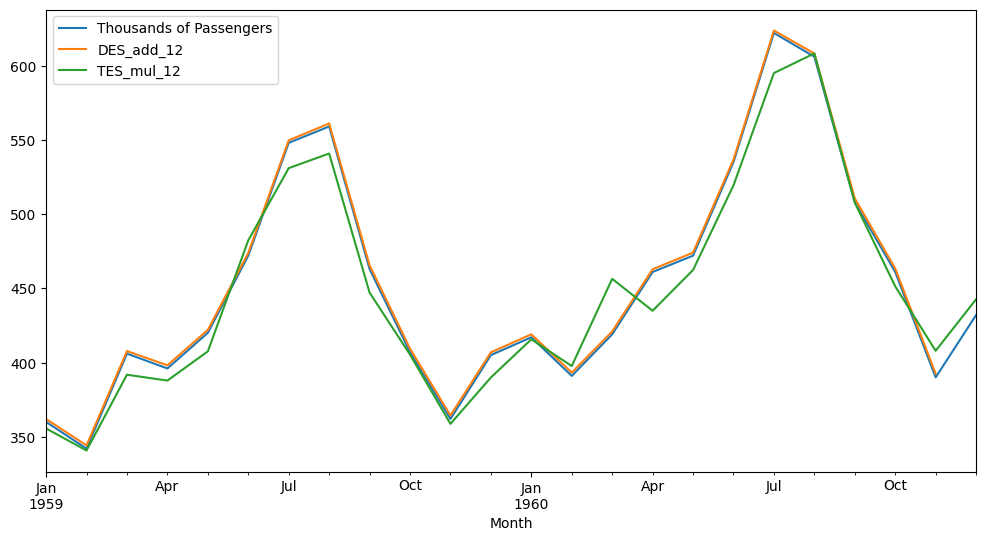

In [45]:
df[['Thousands of Passengers','DES_add_12', 'TES_mul_12']].iloc[-24:].plot(figsize=(12,6))

Based on the plot above, you might think that Triple Exponential Smoothing does a poorer job of fitting than Double Exponential Smoothing. The key point is that while Triple Exponential Smoothing (Holt-Winters) might appear to fit the historical data less well than Double Exponential Smoothing based on the fit to the past data, Triple Exponential Smoothing becomes much more useful when it comes to forecasting future values, especially for data that shows seasonality.

#### Why Triple Exponential Smoothing is Important for Forecasting
Double Exponential Smoothing accounts for trend (upward or downward movement) but doesn't handle seasonality (patterns that repeat at regular intervals). This makes it less suitable for forecasting data with cyclical or seasonal patterns (like monthly sales data or yearly temperature changes). The real strength of Triple Exponential Smoothing is in its forecasting power, not just its ability to fit historical data. By modeling both the trend and seasonal components, it provides more accurate and reliable predictions for future time points where seasonality is important. This is especially valuable in business, economics, and environmental predictions where seasonality plays a significant role.